https://github.com/kairess/CT_lung_segmentation/blob/master/train.ipynb

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.transform import pyramid_reduce, resize

import os, glob

In [2]:
img_list = sorted(glob.glob('C:/Users/12345/OneDrive/Desktop/whatever/hrct/HRCT_volumetric_percentage/tiff/image/*.tiff'))
mask_list = sorted(glob.glob('C:/Users/12345/OneDrive/Desktop/whatever/hrct/HRCT_volumetric_percentage/tiff/mask/*.tiff'))

print(len(img_list), len(mask_list))

3500 3500


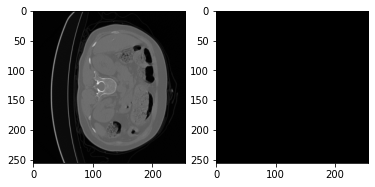

In [3]:
IMG_SIZE = 256

x_data, y_data = np.empty((2, len(img_list), IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)

for i, img_path in enumerate(img_list):
    img = imread(img_path)
    img = resize(img, output_shape=(IMG_SIZE, IMG_SIZE, 1), preserve_range=True)
    x_data[i] = img
    
for i, img_path in enumerate(mask_list):
    img = imread(img_path)
    img = resize(img, output_shape=(IMG_SIZE, IMG_SIZE, 1), preserve_range=True)
    y_data[i] = img
    
y_data /= 255.

fig, ax = plt.subplots(1, 2)
ax[0].imshow(x_data[12].squeeze(), cmap='gray')
ax[1].imshow(y_data[12].squeeze(), cmap='gray')

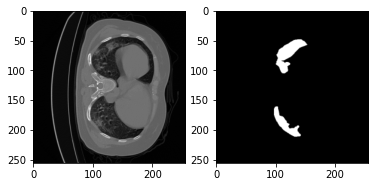

In [4]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(x_data[120].squeeze(), cmap='gray')
ax[1].imshow(y_data[120].squeeze(), cmap='gray')

In [6]:
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2)

np.save('dataset/x_train.npy', x_train)
np.save('dataset/y_train.npy', y_train)
np.save('dataset/x_val.npy', x_val)
np.save('dataset/y_val.npy', y_val)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(2450, 256, 256, 1) (2450, 256, 256, 1)
(1050, 256, 256, 1) (1050, 256, 256, 1)


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU, UpSampling2D
from keras.models import Model, load_model
from keras.callbacks import ReduceLROnPlateau

In [ ]:
x_train = np.load('dataset/x_train.npy')
y_train = np.load('dataset/y_train.npy')
x_val = np.load('dataset/x_val.npy')
y_val = np.load('dataset/y_val.npy')

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

In [3]:
inputs = Input(shape=(256, 256, 1))

net = Conv2D(32, kernel_size=3, activation='relu', padding='same')(inputs)
net = MaxPooling2D(pool_size=2, padding='same')(net)

net = Conv2D(64, kernel_size=3, activation='relu', padding='same')(net)
net = MaxPooling2D(pool_size=2, padding='same')(net)

net = Conv2D(128, kernel_size=3, activation='relu', padding='same')(net)
net = MaxPooling2D(pool_size=2, padding='same')(net)

net = Dense(128, activation='relu')(net)

net = UpSampling2D(size=2)(net)
net = Conv2D(128, kernel_size=3, activation='sigmoid', padding='same')(net)

net = UpSampling2D(size=2)(net)
net = Conv2D(64, kernel_size=3, activation='sigmoid', padding='same')(net)

net = UpSampling2D(size=2)(net)
outputs = Conv2D(1, kernel_size=3, activation='sigmoid', padding='same')(net)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['acc','mse']) #opt(SGD, Adamax, RMSprop), loss()

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856 

In [9]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=30, batch_size=5, callbacks=[
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)
])

Epoch 1/30
490/490 [==============================] - 338s 657ms/step - loss: 0.0023 - acc: 0.9886 - mse: 4.7936e-04 - val_loss: 4.5376e-04 - val_acc: 0.9872 - val_mse: 2.3206e-07 - lr: 0.0010
Epoch 2/30
490/490 [==============================] - 89s 181ms/step - loss: 3.9316e-04 - acc: 0.9887 - mse: 1.7645e-07 - val_loss: 4.3005e-04 - val_acc: 0.9872 - val_mse: 1.7084e-07 - lr: 0.0010
Epoch 3/30
490/490 [==============================] - 126s 257ms/step - loss: 3.8246e-04 - acc: 0.9887 - mse: 1.4705e-07 - val_loss: 4.2784e-04 - val_acc: 0.9872 - val_mse: 1.5817e-07 - lr: 0.0010
Epoch 4/30
490/490 [==============================] - 395s 807ms/step - loss: 3.8048e-04 - acc: 0.9887 - mse: 1.3889e-07 - val_loss: 4.2652e-04 - val_acc: 0.9872 - val_mse: 1.5364e-07 - lr: 0.0010
Epoch 5/30
490/490 [==============================] - 376s 767ms/step - loss: 3.7919e-04 - acc: 0.9887 - mse: 1.3565e-07 - val_loss: 4.2563e-04 - val_acc: 0.9872 - val_mse: 1.5031e-07 - lr: 0.0010
Epoch 6/30
490/490 [

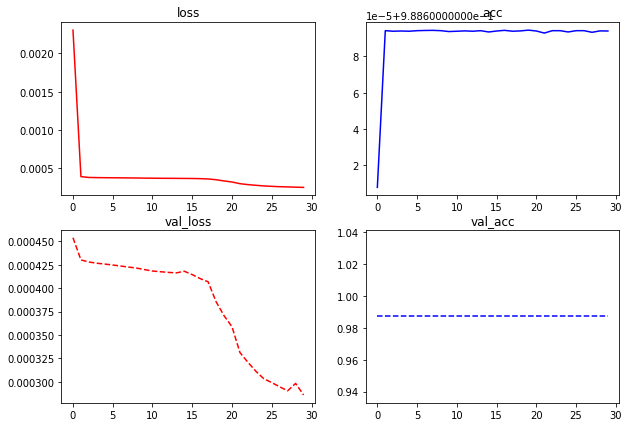

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(10, 7))

ax[0, 0].set_title('loss')
ax[0, 0].plot(history.history['loss'], 'r')
ax[0, 1].set_title('acc')
ax[0, 1].plot(history.history['acc'], 'b')

ax[1, 0].set_title('val_loss')
ax[1, 0].plot(history.history['val_loss'], 'r--')
ax[1, 1].set_title('val_acc')
ax[1, 1].plot(history.history['val_acc'], 'b--')

In [12]:
model.save('trained_model/unet_epoch30_adam_bce.h5')

In [3]:
model=load_model('trained_model/unet_epoch30_adam_bce.h5')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856 

In [4]:
img_list = sorted(glob.glob('C:/Users/12345/OneDrive/Desktop/whatever/hrct/HRCT_volumetric_percentage/tiff_given/patient1/*.tiff'))
print(len(img_list))

575


33/33 [==============================] - 4s 97ms/step


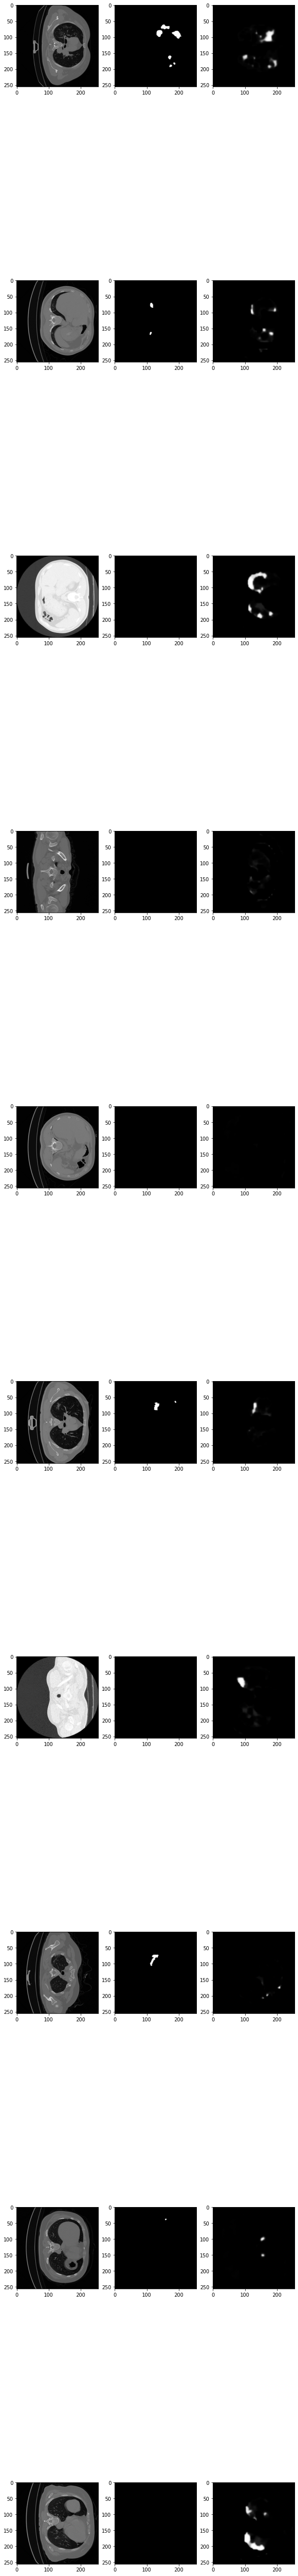

In [13]:
preds = model.predict(x_val)

preds=preds[120:130,:,:,:]
fig, ax = plt.subplots(len(preds), 3, figsize=(10, 100))

for i, pred in enumerate(preds):
    ax[i, 0].imshow(x_val[i].squeeze(), cmap='gray')
    ax[i, 1].imshow(y_val[i].squeeze(), cmap='gray')
    ax[i, 2].imshow(pred.squeeze(), cmap='gray')

In [5]:
IMG_SIZE = 256

x_pred = np.empty(( len(img_list), IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)

for i, img_path in enumerate(img_list):
    img = imread(img_path)
    img = resize(img, output_shape=(IMG_SIZE, IMG_SIZE, 1), preserve_range=True)
    x_pred[i] = img
    

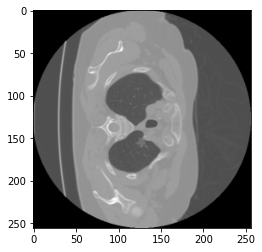

In [15]:
fig, ax = plt.subplots(1, 1)
ax.imshow(x_pred[500].squeeze(), cmap='gray')

In [7]:
print(x_pred.shape)

(563, 256, 256, 1)


In [6]:
np.save('dataset/x_pred1.npy', x_pred)
x_pred=np.load('dataset/x_pred1.npy')

In [7]:
predicts = model.predict(x_pred)

18/18 [==============================] - 26s 636ms/step


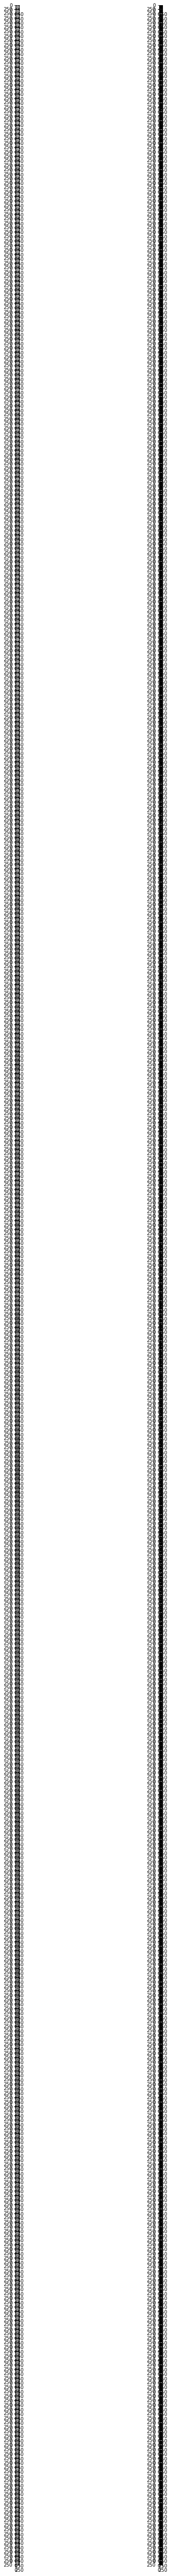

In [8]:
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
preds=predicts
fig, ax = plt.subplots(len(preds), 2, figsize=(10, 100))

for i, pred in enumerate(preds):
    ax[i, 0].imshow(x_pred[i].squeeze(), cmap='gray')
    ax[i, 1].imshow(pred.squeeze(), cmap='gray')

In [8]:
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'qt')

#scroll through the slices

class IndexTracker(object):
    def __init__(self, ax, X):
        self.ax = ax
        ax.set_title('Scroll to Navigate through the DICOM Image Slices')

        self.X = X
        rows, cols, self.slices = X.shape
        self.ind = self.slices//2

        self.im = ax.imshow(self.X[:, :, self.ind])
        self.update()

    def onscroll(self, event):
        print("%s %s" % (event.button, event.step))
        if event.button == 'up':
            self.ind = (self.ind + 1) % self.slices
        else:
            self.ind = (self.ind - 1) % self.slices
        self.update()

    def update(self):
        self.im.set_data(self.X[:, :, self.ind])
        ax.set_ylabel('Slice Number: %s' % self.ind)
        self.im.axes.figure.canvas.draw()

fig, ax = plt.subplots(1,1)

y = np.dstack(predicts)

tracker = IndexTracker(ax, y)

fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()

down -0.025
down -0.13333333333333333
down -0.025
down -0.05
down -0.025
down -0.016666666666666666
down -0.09166666666666666
down -0.041666666666666664
down -0.075
down -0.008333333333333333
down -0.03333333333333333
down -0.11666666666666667
down -0.1
down -0.03333333333333333
down -0.075
down -0.14166666666666666
down -0.225
down -0.058333333333333334
down -0.11666666666666667
down -0.075
down -0.025
down -0.5583333333333333
down -0.058333333333333334
down -0.075
down -0.025
down -0.31666666666666665
down -0.175
down -0.19166666666666668
down -0.30833333333333335
down -0.175
down -0.058333333333333334
down -0.058333333333333334
down -1.1833333333333333
down -0.3
down -0.4666666666666667
down -0.175
down -0.6166666666666667
down -0.75
down -0.3
down -0.025
down -0.6833333333333333
down -2.05
down -0.625
down -2.0
down -0.175
down -0.058333333333333334
down -1.525
down -0.4583333333333333
down -1.3083333333333333
down -0.8083333333333333
down -0.025
down -1.0583333333333333
down -0.26